### Import the libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as pl
#%matplotlib inline

# Probability

### Load the data

In [2]:
dog = pd.read_csv('dogs.csv')
dog.head()

,Breed,DeSexed,Dangerous,Menacing,Sex,MicroChipped
0,All cross breeds,No,No,No,Female,Yes
1,All cross breeds,Yes,No,No,Male,Yes
2,All cross breeds,Yes,No,No,Female,Yes
3,All cross breeds,Yes,No,No,Female,No
4,All cross breeds,Yes,No,No,Female,No


### Explore he proportion of the population 

In [3]:
# counts by Breed
btab = dog["Breed"].value_counts().sort_index()
# convert to proportions and store as a data frame
breed_dist = pd.DataFrame({'counts':btab, 'probs':btab/sum(btab)})
breed_dist

,counts,probs
All cross breeds,205,0.205
All pure and cross breeds,490,0.490
All pure breeds,305,0.305


### Explore Joint probabilities

In [4]:
# Joint probabilities by Sex and Microchipped: use normalise='all'
ctab = pd.crosstab(dog['Sex'], dog['MicroChipped'], 
                   margins=True, margins_name='Total', normalize='all')
ctab

MicroChipped,No,Yes,Total
Sex,,,
Female,0.221,0.292,0.513
Male,0.219,0.268,0.487
Total,0.440,0.560,1.000


### Explore Conditional probabilities
- The conditional probability P(A|B) = P(event A occurs given that event B has occurred) 

In [5]:
# Conditional probabilities for Gender given microchipped: use normalise='columns' (normalise down the columns)
ctab = pd.crosstab(dog['Sex'], dog['MicroChipped'], 
                   normalize='columns')
ctab

MicroChipped,No,Yes
Sex,,
Female,0.502273,0.521429
Male,0.497727,0.478571


In [6]:
# Conditional probabilities for Qualification given Gender: use normalise='index' (normalise across the rows)
ctab = pd.crosstab(dog['Sex'], dog['MicroChipped'], 
                   normalize='index')
ctab

MicroChipped,No,Yes
Sex,,
Female,0.430799,0.569201
Male,0.449692,0.550308


### Probability distributions

Note: 

  * A **probability mass function** $P(X=x)$ is the probability that a discrete or categorical random variable $X$ takes a particular value $x$
  * A **cumulative distribution function** $P(X\leq x)$ is the probability that a nueerical random variable $X$ (which can be discrete or continuous) takes a value less than or equal to a particular value $x$.
  
A **hypergeometric random variable** $X$ is a random variable with three parameters.   $X$ is the number of items a certain kind in a sample of $N$ drawn from a population of size $M$ which contains $n$ items of that kind.  

#####  The probability that  𝑋  is 5.

In [7]:
import numpy as np
from scipy.stats import hypergeom

n= 1000
N = 20
M = 5000
x=5

prob=hypergeom.pmf(x, M, n, N)  # hypergeom.pmf(x, M, n, N)
print("Pr(X=", x, ") = ", prob, sep="")

Pr(X=5) = 0.17486573799562924


##### The probability that $X$ is less than 5.

In [8]:
prob=hypergeom.cdf(x-1, M, n, N) # x < 5 = x <= 4
print("Pr(X<", x, ") = ", prob, sep="")

Pr(X<5) = 0.6297359750433553


##### Tthe probability that $X$ is in the range 5 to 10 **inclusive**.

In [9]:
prob = hypergeom.cdf(10, M, n, N)-hypergeom.cdf(4, M, n, N) # need 10 -5, so x<=10 - x<=4
print("Pr(", 5, "<=X", "<=",10,") = ", prob, sep="")

Pr(5<=X<=10) = 0.3697162204776304


##### A bar chart of the probability of each possible value of $X$

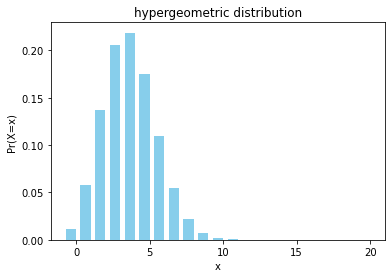

In [10]:
x = np.arange(0, 21)
M = 5000
n = 1000
N = 20
probs = hypergeom.pmf(x, M, n, N)

# Plot these probabilities
width = 0.70  # the width of the bars
fig, ax = pl.subplots(1,1)
rects = ax.bar(x - width/2, probs, width, color='SkyBlue')
ax.set(xlabel='x', ylabel='Pr(X=x) ', title='hypergeometric distribution');

##### The expected (mean) value of $X$.

In [11]:
x = np.arange(0, 21)
probs = hypergeom.pmf(x, M, n, N)
Ex = sum(x*probs)
print(Ex)

4.000000000043414


# Model fitting

#### Load the data

In [12]:
cm2016 = pd.read_csv('cm2016.csv')
cm2016[cm2016.isnull().any(axis=1)]

,Country,Code,ChildMortalityPct,GDPPerCapita,Population,Continent
3,American Samoa,ASM,NaN,NaN,56000.0,Oceania
4,Andorra,AND,0.2700,NaN,77000.0,Europe
6,Anguilla,AIA,NaN,NaN,14000.0,North America
7,Antigua and Barbuda,ATG,0.8500,NaN,95000.0,North America
10,Aruba,ABW,1.6265,NaN,105000.0,North America
...,...,...,...,...,...,...
223,United States Virgin Islands,VIR,0.9983,NaN,105000.0,North America
226,Vanuatu,VUT,2.7600,NaN,278000.0,Oceania
227,Vatican,VAT,NaN,NaN,1000.0,Europe
230,Wallis and Futuna,WLF,NaN,NaN,12000.0,Oceania


In [13]:
cm2016 = cm2016.loc[-np.isnan(cm2016['ChildMortalityPct'])]
cm2016 = cm2016.loc[-np.isnan(cm2016['GDPPerCapita'])]
cm2016.head()

,Country,Code,ChildMortalityPct,GDPPerCapita,Population,Continent
0,Afghanistan,AFG,7.04,1929.0,35383000.0,Asia
1,Albania,ALB,1.35,10342.0,2886000.0,Europe
2,Algeria,DZA,2.52,14331.0,40551000.0,Africa
5,Angola,AGO,8.25,8453.0,28842000.0,Africa
8,Argentina,ARG,1.11,18875.0,43508000.0,South America


#### Explore the data

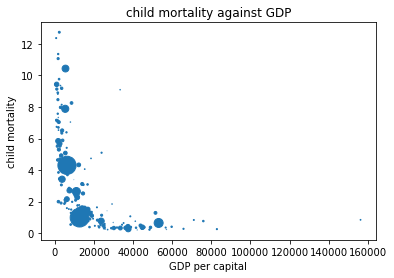

In [14]:
fig, ax = pl.subplots(1,1)
pl.scatter(cm2016['GDPPerCapita'], cm2016['ChildMortalityPct'], marker='.', s = cm2016['Population']/1000000);
ax.set(ylabel='child mortality', xlabel='GDP per capital', title = 'child mortality against GDP');

#### Apply a log for GDP and Child Mortality, adding these columns to the data frame.

In [15]:
cm2016['log_GDPPerCapita'] = np.log(cm2016['GDPPerCapita'])
cm2016['log_ChildMortalityPct'] = np.log(cm2016['ChildMortalityPct'])
cm2016.head()

,Country,Code,ChildMortalityPct,GDPPerCapita,Population,Continent,log_GDPPerCapita,log_ChildMortalityPct
0,Afghanistan,AFG,7.04,1929.0,35383000.0,Asia,7.564757,1.951608
1,Albania,ALB,1.35,10342.0,2886000.0,Europe,9.243969,0.300105
2,Algeria,DZA,2.52,14331.0,40551000.0,Africa,9.570180,0.924259
5,Angola,AGO,8.25,8453.0,28842000.0,Africa,9.042277,2.110213
8,Argentina,ARG,1.11,18875.0,43508000.0,South America,9.845594,0.104360


#### Plot the logged data

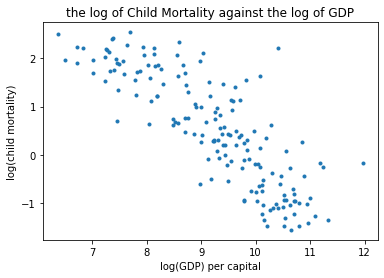

In [16]:
fig, ax = pl.subplots(1,1)
pl.scatter(cm2016['log_GDPPerCapita'], cm2016['log_ChildMortalityPct'], marker='.');
ax.set(ylabel='log(child mortality)', xlabel='log(GDP) per capital', title = 'the log of Child Mortality against the log of GDP');

#### Fit a regression model, use ols() from statsmodels.formula.api

In [17]:
# Print out a summary of the model fit
fittedmodel = smf.ols("log_ChildMortalityPct ~ log_GDPPerCapita", data=cm2016).fit()
fittedmodel.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_ChildMortalityPct   R-squared:                       0.687
Model:                               OLS   Adj. R-squared:                  0.685
Method:                    Least Squares   F-statistic:                     357.4
Date:                   Mon, 04 Oct 2021   Prob (F-statistic):           6.11e-43
Time:                           21:17:56   Log-Likelihood:                -161.53
No. Observations:                    165   AIC:                             327.1
Df Residuals:                        163   BIC:                             333.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.8915      0.393     20.085      0.000       7.116       8.667
log_GDPPerCapita    -0.7992      0.042    -18.905      0.000      -0.883      -0.716
==============================================================================
Omnibus:                       17.683   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.357
Skew:                           0.708   Prob(JB):                     2.30e-05
Kurtosis:                       4.048   Cond. No.                         73.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

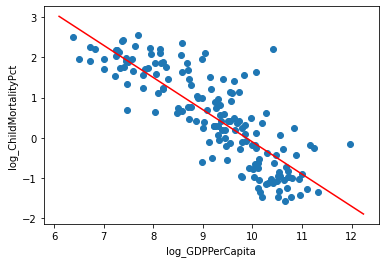

In [18]:
# Plot the fitted relationship onto the data
x=cm2016['log_GDPPerCapita']
y=cm2016['log_ChildMortalityPct']
predictions = fittedmodel.predict(cm2016)
residuals = y - predictions

# linear model
fig, ax = pl.subplots(1,1)
pl.scatter(x, y, marker='o');
ax.set(xlabel='log_GDPPerCapita', ylabel='log_ChildMortalityPct');
xmin, xmax = ax.get_xbound() # get the plot bounds
xp = np.linspace(xmin, xmax, 101)
xpmat = pd.DataFrame({'log_GDPPerCapita':xp})
yp = fittedmodel.predict(xpmat)
pl.plot(xp, yp, 'r-');

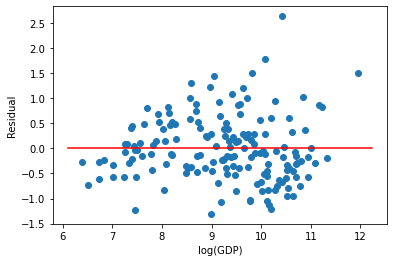

In [19]:
# Draw a scatter plot of the residuals
fig, ax = pl.subplots(1,1)
pl.scatter(x, residuals, marker='o');
ax.set(xlabel='log(GDP)', ylabel='Residual');
xmin, xmax = ax.get_xbound() # get the plot bounds
xp = [xmin,xmax] # store these as a vector
yp = [0, 0]
pl.plot(xp, yp, 'r-');

#### Add a quadratic term to the model.

In [20]:
cm2016['log_GDPPerCapita2'] = cm2016['log_GDPPerCapita']**2
# Print out a summary of the model fit
fittedmodel2 = smf.ols("log_ChildMortalityPct ~ log_GDPPerCapita+log_GDPPerCapita2", data=cm2016).fit()
fittedmodel2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_ChildMortalityPct   R-squared:                       0.689
Model:                               OLS   Adj. R-squared:                  0.685
Method:                    Least Squares   F-statistic:                     179.6
Date:                   Mon, 04 Oct 2021   Prob (F-statistic):           7.72e-42
Time:                           21:17:57   Log-Likelihood:                -160.89
No. Observations:                    165   AIC:                             327.8
Df Residuals:                        162   BIC:                             337.1
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.9609      2.628      1.888      0.061      -0.228      10.150
log_GDPPerCapita     -0.1373      0.588     -0.233      0.816      -1.299       1.024
log_GDPPerCapita2    -0.0367      0.033     -1.128      0.261      -0.101       0.028
==============================================================================
Omnibus:                       19.609   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.402
Skew:                           0.730   Prob(JB):                     3.05e-06
Kurtosis:                       4.249   Cond. No.                     4.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

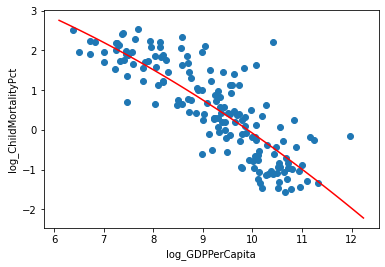

In [21]:
# Plot the fitted relationship onto the data
x=cm2016['log_GDPPerCapita']
y=cm2016['log_ChildMortalityPct']
predictions = fittedmodel2.predict(cm2016)
residuals = y - predictions

# fitted curve model
fig, ax = pl.subplots(1,1)
pl.scatter(x, y, marker='o');
ax.set(xlabel='log_GDPPerCapita', ylabel='log_ChildMortalityPct');
xmin, xmax = ax.get_xbound() # get the plot bounds
xp = np.linspace(xmin, xmax, 101)
xpmat = pd.DataFrame({'log_GDPPerCapita':xp, 'log_GDPPerCapita2':xp**2})
yp = fittedmodel2.predict(xpmat)
pl.plot(xp, yp, 'r-');

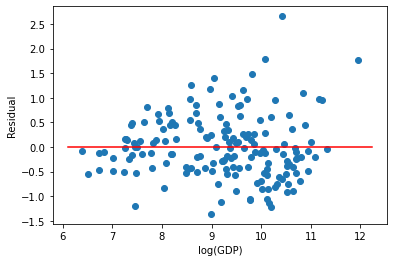

In [22]:
#Draw a scatter plot of the residuals
fig, ax = pl.subplots(1,1)
pl.scatter(x, residuals, marker='o');
ax.set(xlabel='log(GDP)', ylabel='Residual');
xmin, xmax = ax.get_xbound() # get the plot bounds
xp = [xmin,xmax] # store these as a vector
yp = [0, 0]
pl.plot(xp, yp, 'r-');

#### Comments:
1. The quadratic term does not significantly improve the fit. It also has more parameter, meaning that the likelyhood of overfiting is higher.
2. The BIC is lower in the model with a linear fit, incating model without the quadratic term is a better model.